# Imports

In [76]:

import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import warnings
import data_func.read_data as read_data
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")



# Load datasets

In [77]:
import data_func.read_data as read_data

dataframes = read_data.get_training_data()
X_frames_train = dataframes[0]
Y_frames_train = dataframes[1]
X_frames_test = read_data.get_test_data()


In [78]:
XTRA = X_frames_train[0]
XTRB = X_frames_train[1]
XTRC = X_frames_train[2]

YA = Y_frames_train[0]
YB = Y_frames_train[1]
YC = Y_frames_train[2]


In [79]:
print("A: \n", len(XTRA))
ind = XTRA[(XTRA['date_forecast'] == pd.to_datetime('2022-10-21 00:00:00'))].index
print(ind)
XTRA = XTRA.drop(ind).reset_index(drop=True)
print(len(XTRA))



A: 
 136245
Int64Index([118664], dtype='int64')
136244


In [80]:
print("B: \n", len(XTRB))
ind = XTRB[(XTRB['date_forecast'] == pd.to_datetime('2022-05-02 21:00:00'))].index
print(ind)
XTRB = XTRB.drop(ind).reset_index(drop=True)
print(len(XTRB))

print("C: \n",len(XTRC))
ind = XTRC[(XTRC['date_forecast'] == pd.to_datetime('2022-04-25 21:00:00'))].index
print(ind)
XTRC = XTRC.drop(ind).reset_index(drop=True)
print(len(XTRC))


B: 
 134505
Int64Index([116916], dtype='int64')
134504
C: 
 134401
Int64Index([116244], dtype='int64')
134400


# Data clean up

[]
[635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 707, 708, 709, 710, 711, 712, 713, 1348, 1349, 1350, 1351, 1352, 3093, 3094, 3095, 3096, 3097, 3098, 3099, 3100, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 3680, 3681, 3682, 3683, 3684, 7211, 7212, 7213, 7214, 7215, 7216, 7217, 7218, 7219, 7220, 7221, 7222, 7223, 7224, 7225, 7226, 7227, 7228, 7229, 7230, 7231, 7232, 7233, 7234, 7235, 7236, 7237, 7238, 7239, 7240, 7241, 7242, 7243, 7244, 7245, 7246, 7247, 7248, 7249, 7250, 7251, 7252, 7253, 7254, 7255, 7256,

<Axes: title={'center': 'Target C Clean'}, xlabel='time'>

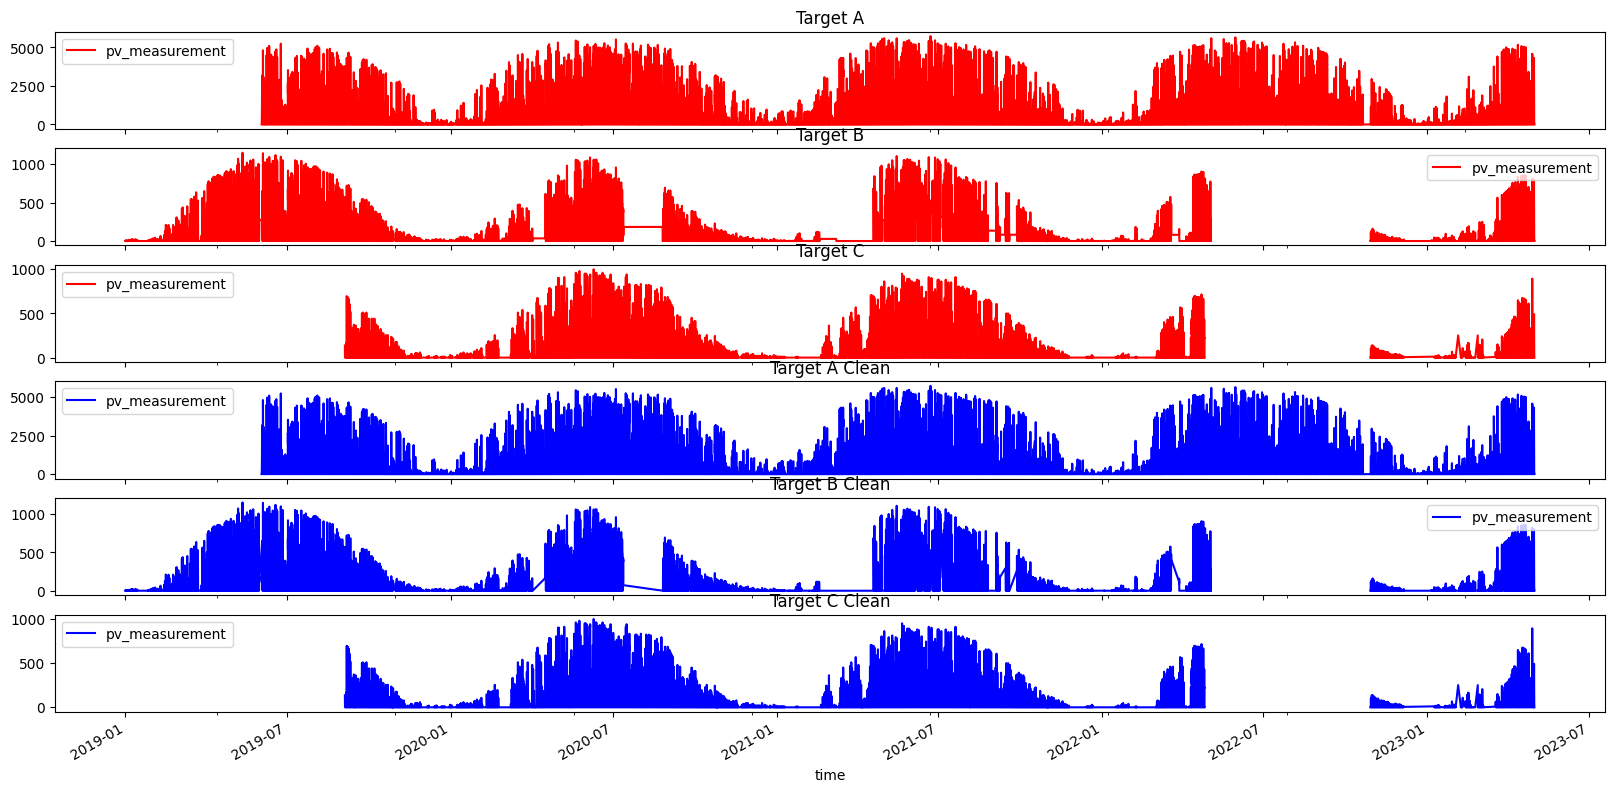

In [81]:
def fix_y_holes(y: pd.DataFrame) -> pd.DataFrame:
    Y = y
    drop_val = None
    index_dropper = []
    for i in range(1, len(Y)-4): # Since we match on 4 consecutive values.
        if Y['pv_measurement'].iloc[i] != 0:
            if (Y['pv_measurement'].iloc[i] == Y['pv_measurement'].iloc[i+1] and Y['pv_measurement'].iloc[i+1] == Y['pv_measurement'].iloc[i+2] and Y['pv_measurement'].iloc[i+2] == Y['pv_measurement'].iloc[i+3]):
                drop_val = Y['pv_measurement'].iloc[i]
        if Y['pv_measurement'].iloc[i] == drop_val:
            index_dropper.append(i)
        else:
            if drop_val != None:
                drop_val = None
    print(index_dropper)
    return Y.drop(index_dropper)
    
import matplotlib.pylab as plt
fig, axs = plt.subplots(6, 1, figsize=(20, 10), sharex=True)
YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[0], title='Target A', color='red')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[1], title='Target B', color='red')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[2], title='Target C', color='red')


YA = fix_y_holes(YA)
YB = fix_y_holes(YB)
YC = fix_y_holes(YC)

YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[3], title='Target A Clean', color='blue')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[4], title='Target B Clean', color='blue')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[5], title='Target C Clean', color='blue')



# Data Aggregation

In [82]:
# making shure that target values line up with x_values
import data_func.aggregation as data_agg

categorical_col = ['dew_or_rime:idx', 'precip_type_5min:idx', 'is_day:idx', 'is_in_shadow:idx']

def aggregate_correct_x(x: pd.DataFrame) -> pd.DataFrame:
   '''
   Takes a given dataframe and returns an aggregated dataframe based on selected categorical functions. 
   Assumes grouping of 4.
   '''
   categorical = x[["date_forecast"] + categorical_col]
   mean = x.drop(columns=categorical_col)

   categorical = data_agg.gen_agg(categorical, agg_type=data_agg.stocastic_median, merge_on = 'first')
   mean = data_agg.gen_agg(mean, "mean", merge_on = 'first')

   return pd.merge(categorical, mean, on="date_forecast")

def data_allign(x_train, y_train):

  y_train.dropna(inplace=True)
  x_train = aggregate_correct_x(x_train)
  combined_data = pd.merge(x_train, y_train, left_on='date_forecast', right_on='time')
  y_train = combined_data['pv_measurement']

  if 'time' and 'pv_measurement' in combined_data.columns:
    combined_data.drop(columns=['time', 'pv_measurement'], inplace=True)
    
  return combined_data, y_train



X_train = [XTRA, XTRB, XTRC]
Y_train = [YA, YB, YC]

for i in range(len(X_train)):
    X_train[i], Y_train[i] = data_allign(X_train[i], Y_train[i])

for j in range(len(X_frames_test)):
    X_frames_test[j] = aggregate_correct_x(X_frames_test[j])


In [83]:
#Verify length matches
for x in range(len(X_train)):
    print("x,y: ", len(X_train[x]), len(Y_train[x]))


x,y:  34060 34060
x,y:  29596 29596
x,y:  26028 26028


In [84]:
X_train[0].tail()


,date_forecast,dew_or_rime:idx,precip_type_5min:idx,is_day:idx,is_in_shadow:idx,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,...,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,estimated,estimation_calc_forecast_difference
34055,2023-04-30 19:00:00,0,0,0,1,4.55,1.27650,1674.199951,84464.945312,4.225,...,0.000,275.024994,96.699997,23417.074219,5.175,4.800,1.925,0.0,1.0,44545.0
34056,2023-04-30 20:00:00,0,0,0,1,4.50,1.27975,1762.400024,2270.875000,0.000,...,0.000,274.650024,94.525002,21084.050781,4.650,4.025,2.300,0.0,1.0,48145.0
34057,2023-04-30 21:00:00,0,0,0,1,4.50,1.28100,1696.650024,0.000000,0.000,...,0.000,274.524994,95.675003,20792.500000,4.450,3.575,2.600,0.0,1.0,51745.0
34058,2023-04-30 22:00:00,0,0,0,1,4.50,1.28100,1353.400024,0.000000,0.000,...,0.100,274.325012,98.875000,14158.099609,4.100,3.175,2.550,0.0,1.0,55345.0
34059,2023-04-30 23:00:00,0,0,0,1,4.50,1.28100,1626.574951,0.000000,0.000,...,0.075,274.225006,99.699997,11872.299805,3.750,2.725,2.550,0.0,1.0,58945.0


# Feature engineering

In [85]:
import data_func.timeseasonality as DTS
import data_func.one_hot_encoding as OHE
import data_func.date_forecast as DF
for i in range(len(X_train)):
    X_train[i] = DTS.append_seasonal_columns(X_train[i])
    X_train[i] = DF.date_forecast_columns(X_train[i])

for i in range(len(X_frames_test)):
    X_frames_test[i] = DTS.append_seasonal_columns(X_frames_test[i])
    X_frames_test[i] = DF.date_forecast_columns(X_frames_test[i])    
 

# THIS SECTION CAN ONLY WORK IF THE PREVIOUS AGGREGATION IS DONE INDIVIDUALLY FOR CATEGORICAL DATA
# import data_func.one_hot_encoding as OHE

def fix_categorical(train: pd.DataFrame, test: pd.DataFrame):
    temp = pd.concat([train, test], ignore_index=True)
    index_train = temp[(temp['date_forecast'] < test['date_forecast'].iloc[0])].index
    return temp.drop(index_train)

OH_columns = ['dew_or_rime:idx', 'precip_type_5min:idx']

for i in range(len(X_frames_test)):
     X_train[i] = OHE.one_hot_encode(X_train[i],OH_columns)
     X_frames_test[i] = OHE.one_hot_encode(X_frames_test[i], OH_columns)
     X_frames_test[i] = fix_categorical(X_train[i], X_frames_test[i])
    #  X_train[i].drop(columns=['date_forecast'], inplace=True)
    #  X_frames_test[i].drop(columns=['date_forecast'], inplace=True)


# Data cleaning

In [86]:
# Show null values for all training sets

count_a = X_train[0].isna().sum()
count_b = X_train[1].isna().sum()
count_c = X_train[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]


,A,B,C
ceiling_height_agl:m,6126,4588,5122
cloud_base_agl:m,2362,2025,2199
snow_density:kgm3,32920,28040,24561


In [87]:
# Show null values for all test sets

count_a = X_frames_test[0].isna().sum()
count_b = X_frames_test[1].isna().sum()
count_c = X_frames_test[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]


,A,B,C
ceiling_height_agl:m,188,180,202
cloud_base_agl:m,70,65,88
snow_density:kgm3,720,720,720
dew_or_rime:idx_-1,720,720,0
precip_type_5min:idx_2,720,720,720
precip_type_5min:idx_3,720,720,720
precip_type_5min:idx_5,720,720,720


In [88]:
# Removes nan or fills it
values = {"ceiling_height_agl:m": 20000, "cloud_base_agl:m": 20000}

for i in range(len(X_train)):
    X_train[i].drop(columns=['snow_density:kgm3', 'elevation:m', 'year'], inplace=True)
    X_frames_test[i].drop(columns=['snow_density:kgm3', 'elevation:m', 'year'], inplace=True)
    X_train[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(0, inplace=True) # fills remaining NaN vals with 0, (specifically for one-hot encoded columns with NaN)




In [89]:

print(X_train[0]['estimated'])


0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
34055    1.0
34056    1.0
34057    1.0
34058    1.0
34059    1.0
Name: estimated, Length: 34060, dtype: float64


In [90]:
def chat_gpt_features(df: pd.DataFrame) -> pd.DataFrame:
    # Convert the 'date_forecast' to datetime and set it as index
    df['date_forecast'] = pd.to_datetime(df['date_forecast'])
    df.set_index('date_forecast', inplace=True)
    df.sort_index(inplace=True)

    # Now apply the rolling function
    # # Fjerne disse to
    # df['max_air_density_3h'] = df['air_density_2m:kgm3'].rolling('3h').max()
    # df['min_air_density_3h'] = df['air_density_2m:kgm3'].rolling('3h').min()
    
    df['total_solar_rad_1h'] = df['direct_rad_1h:J'] + df['diffuse_rad_1h:J']

    # fjern denne
    df['total_wind_speed_10m'] = (df['wind_speed_u_10m:ms']**2 + df['wind_speed_v_10m:ms']**2)**0.5

    df['total_snow_1h'] = df[['fresh_snow_1h:cm', 'snow_melt_10min:mm']].sum(axis=1)

    # df['pressure_variation_3h'] = df['sfc_pressure:hPa'].diff(periods=3)
    return df


for i in range(len(X_train)):
    X_train[i] = chat_gpt_features(X_train[i])
    X_frames_test[i] = chat_gpt_features(X_frames_test[i])


In [91]:

def combine_features(df, listOfFeaturesToCombine):
    for features in listOfFeaturesToCombine:
        new_col_name = features[0] + '_mean'
        df[new_col_name] = df[features].mean(axis=1)
    return df

listOfFeaturesToCombine = [['msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'sfc_pressure:hPa'],
                            ["diffuse_rad:W", "direct_rad:W"], 
                            ['diffuse_rad_1h:J', 'direct_rad_1h:J'],
                           ['effective_cloud_cover:p', 'total_cloud_cover:p']
                    ]

for i in range(len(X_train)):
    X_train[i] = combine_features(X_train[i], listOfFeaturesToCombine)
    X_frames_test[i] = combine_features(X_frames_test[i], listOfFeaturesToCombine)
X_train[0].describe().transpose()

# top_10_worst_features = ['precip_type_5min:idx_5', 'wind_speed_w_1000hPa:ms', 'dew_or_rime:idx_-1', 'precip_type_5min:idx_2', 'dew_or_rime:idx_1', 'snow_drift:idx', 'dew_or_rime:idx_0', 'prob_rime:p', 'precip_type_5min:idx_3', 'fresh_snow_1h:cm',
#                          'fresh_snow_3h:cm', 'snow_melt_10min:mm', 'fresh_snow_6h:cm', 'snow_depth:cm', 'precip_type_5min:idx_1',
#                          'rain_water:kgm2', 'fresh_snow_12h:cm']
# top_5_worst_features = ['snow_drift:idx', 'dew_or_rime:idx_-1', 'dew_or_rime:idx_0', 'precip_type_5min:idx_5', 'precip_type_5min:idx_2', 
#                         'wind_speed_u_10m:ms', 'wind_speed_w_1000hPa:ms','wind_speed_v_10m:ms'
#                         ]
# for i in range(len(X_train)):
#     X_train[i].drop(columns=top_5_worst_features, inplace=True)
#     X_frames_test[i].drop(columns=top_5_worst_features, inplace=True)

# for i in range(len(X_train)):
#     X_train[i].drop(columns=top_10_worst_features, inplace=True)
#     X_frames_test[i].drop(columns=top_10_worst_features, inplace=True)


# for i in range(len(X_train)):
#     X_train[i]['diffuse_rad:W_mean_prev_hour'] = X_train[i]['diffuse_rad:W_mean'].shift(1)
#     X_train[i]['diffuse_rad_1h:J_mean_prev_hour'] = X_train[i]['diffuse_rad_1h:J_mean'].shift(1)
#     X_frames_test[i]['diffuse_rad:W_mean_prev_hour'] = X_frames_test[i]['diffuse_rad:W_mean'].shift(1)
#     X_frames_test[i]['diffuse_rad_1h:J_mean_prev_hour'] = X_frames_test[i]['diffuse_rad_1h:J_mean'].shift(1)




,count,mean,std,min,25%,50%,75%,max
is_day:idx,34060.0,0.486524,0.499826,0.0,0.0,0.0,1.0,1.0
is_in_shadow:idx,34060.0,0.526395,0.49931,0.0,0.0,1.0,1.0,1.0
absolute_humidity_2m:gm3,34060.0,6.32236,2.799474,0.7,4.2,5.8,8.25,17.35
air_density_2m:kgm3,34060.0,1.253279,0.037206,1.145,1.2275,1.2515,1.27725,1.42625
ceiling_height_agl:m,34060.0,6036.402832,6939.430176,27.849998,1286.950012,2651.512451,7567.643433,20000.0
...,...,...,...,...,...,...,...,...
total_snow_1h,34060.0,0.00753,0.083672,0.0,0.0,0.0,0.0,3.55
msl_pressure:hPa_mean,34060.0,1004.529297,12.679372,939.75,996.625,1005.46875,1013.3125,1038.943726
diffuse_rad:W_mean,34060.0,47.350224,79.670685,0.0,0.0,1.075,63.8,386.637512
diffuse_rad_1h:J_mean,34060.0,170460.8125,283951.21875,0.0,0.0,9506.400391,229745.234375,1382627.125


In [92]:
print(X_frames_test[0].columns)


Index(['is_day:idx', 'is_in_shadow:idx', 'absolute_humidity_2m:gm3',
       'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J',
       'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'fresh_snow_12h:cm', 'fresh_snow_1h:cm',
       'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm',
       'msl_pressure:hPa', 'precip_5min:mm', 'pressure_100m:hPa',
       'pressure_50m:hPa', 'prob_rime:p', 'rain_water:kgm2',
       'relative_humidity_1000hPa:p', 'sfc_pressure:hPa', 'snow_depth:cm',
       'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2',
       'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
       't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
       'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
       'wind_speed_w_1000hPa:ms', 'estimated',
       'estimation_calc_forecast_differ

In [93]:
# Split the data into training and validation sets

x_train_a, x_val_a, y_train_a, y_val_a = train_test_split(X_train[0], Y_train[0], test_size=0.17, random_state=42)
x_train_b, x_val_b, y_train_b, y_val_b = train_test_split(X_train[1], Y_train[1], test_size=0.17, random_state=42)
x_train_c, x_val_c, y_train_c, y_val_c = train_test_split(X_train[2], Y_train[2], test_size=0.17, random_state=42)


# Training the model

In [94]:



# Use params from hyperparameter tuning using optuna
params_a = {'random_state': 42, 'learning_rate': 0.039975576144155645, 'depth': 9, 'subsample': 0.4504678933801176, 'colsample_bylevel': 0.9773225861097778, 'min_data_in_leaf': 90}
params_b = {'random_state': 42, 'learning_rate': 0.023765834908014156, 'depth': 10, 'subsample': 0.8298593330195755, 'colsample_bylevel': 0.6060393047650714, 'min_data_in_leaf': 61}
params_c = {'random_state': 42, 'learning_rate': 0.060183973978509046, 'depth': 10, 'subsample': 0.28819995411353627, 'colsample_bylevel': 0.39818319507473743, 'min_data_in_leaf': 77}

# # Hypertuned params, but worse :(
# params_a = {'random_state': 42, 'learning_rate': 0.09566223811599815, 'depth': 7, 'subsample': 0.960801961471582, 'colsample_bylevel': 0.6043383106745279, 'min_data_in_leaf': 78}
# params_b = {'random_state': 42, 'learning_rate': 0.04250298579274471, 'depth': 10, 'subsample': 0.5902141253689043, 'colsample_bylevel': 0.4702544263427683, 'min_data_in_leaf': 87}
# params_c = {'random_state': 42, 'learning_rate': 0.008810167623455675, 'depth': 10, 'subsample': 0.8621321557173095, 'colsample_bylevel': 0.6774949043850594, 'min_data_in_leaf': 25}

model_a = CatBoostRegressor(**params_a)
model_b = CatBoostRegressor(**params_b)
model_c = CatBoostRegressor(**params_c)


model_a.fit(x_train_a, y_train_a)
model_b.fit(x_train_b, y_train_b)
model_c.fit(x_train_c, y_train_c)


0:	learn: 1133.7259685	total: 28.7ms	remaining: 28.7s
1:	learn: 1098.4736697	total: 45.6ms	remaining: 22.7s
2:	learn: 1064.7118187	total: 61ms	remaining: 20.3s
3:	learn: 1031.9751265	total: 78ms	remaining: 19.4s
4:	learn: 1001.1372609	total: 92.5ms	remaining: 18.4s
5:	learn: 971.4339464	total: 109ms	remaining: 18.1s
6:	learn: 943.6358842	total: 123ms	remaining: 17.4s
7:	learn: 916.8253341	total: 136ms	remaining: 16.9s
8:	learn: 891.2914542	total: 153ms	remaining: 16.8s
9:	learn: 866.4053807	total: 165ms	remaining: 16.3s
10:	learn: 843.2660707	total: 177ms	remaining: 15.9s
11:	learn: 821.3441985	total: 191ms	remaining: 15.7s
12:	learn: 800.2448583	total: 208ms	remaining: 15.8s
13:	learn: 780.1572252	total: 222ms	remaining: 15.7s
14:	learn: 761.2574801	total: 236ms	remaining: 15.5s
15:	learn: 742.8285739	total: 253ms	remaining: 15.6s
16:	learn: 725.3214703	total: 268ms	remaining: 15.5s
17:	learn: 709.2251751	total: 280ms	remaining: 15.3s
18:	learn: 693.8759734	total: 296ms	remaining: 15.

In [95]:
y_val_a_pred = model_a.predict(x_val_a) * x_val_a['is_day:idx']
y_val_b_pred = model_b.predict(x_val_b) * x_val_b['is_day:idx']
y_val_c_pred = model_c.predict(x_val_c) * x_val_c['is_day:idx']


# Evaluate prediction

In [96]:
# Evaluate the model based on the validation data

mse_a = mean_squared_error(y_val_a, y_val_a_pred)
print("MSE for A: ", mse_a)
mse_b = mean_squared_error(y_val_b, y_val_b_pred)
print("MSE for B: ", mse_b)
mse_c = mean_squared_error(y_val_c, y_val_c_pred)
print("MSE for C: ", mse_c)
print("Mean MSE: ", (mse_a + mse_b + mse_c) / 3)

# Evaluate the predictions

score_a = model_a.score(x_val_a, y_val_a)
score_b = model_b.score(x_val_b, y_val_b)
#score_c = model_c.score(x_val_c, y_val_c)

print("Score A: ", score_a)
print("Score B: ", score_b)
#print("Score C: ", score_c)
print('')

#Mean MSE:  41875.359992707075

# 147: Mean MSE: 41241.868700493964



MSE for A:  119186.47501380787
MSE for B:  3169.625250904176
MSE for C:  1819.495747129481
Mean MSE:  41391.865337280506
Score A:  0.9088846463086212
Score B:  0.9215847691453817



In [97]:
mae_a = mean_absolute_error(y_val_a, y_val_a_pred)
print("MAE for A: ", mae_a)
mae_b = mean_absolute_error(y_val_b, y_val_b_pred)
print("MAE for B: ", mae_b)
mae_c = mean_absolute_error(y_val_c, y_val_c_pred)
print("MAE for C: ", mae_c)
print('total MAE: ', (mae_a + mae_b + mae_c))
print('mean MAE: ', (mae_a + mae_b + mae_c) / 3)

# MAE for A:  153.7542843577413
# MAE for B:  22.167841037841136
# MAE for C:  16.982720853153175
# total MAE:  192.90484624873562
# mean MAE:  64.30161541624521

# 147: total MAE:  191.30648556069812


MAE for A:  153.48991347221175
MAE for B:  22.188629666315553
MAE for C:  16.836155190177067
total MAE:  192.51469832870438
mean MAE:  64.17156610956813


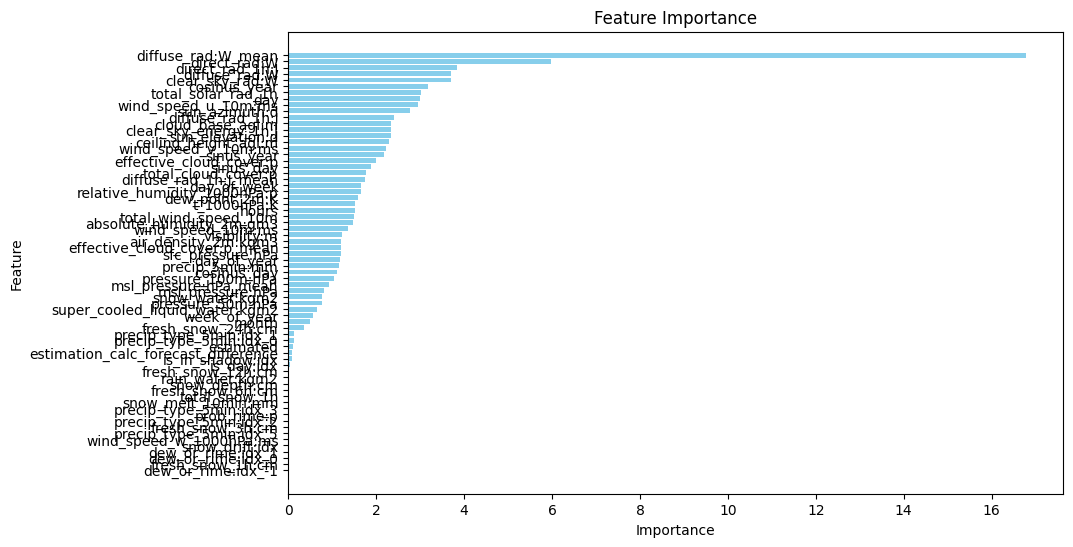

In [98]:
import matplotlib.pyplot as plt

feature_importance = model_a.get_feature_importance()
# Create a DataFrame to store feature names and their importance scores
importance_df = pd.DataFrame({'Feature': x_train_a.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance scores in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot to visualize feature importance

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most important features at the top
plt.show()


In [99]:
worst_features = importance_df.sort_values(by='Importance', ascending=True).head(5)['Feature'].tolist()
print(worst_features)


['dew_or_rime:idx_-1', 'wind_speed_w_1000hPa:ms', 'snow_drift:idx', 'fresh_snow_1h:cm', 'dew_or_rime:idx_0']


# Make predictions

In [100]:
# Train the model on the entire training data
model_a.fit(X_train[0], Y_train[0])
model_b.fit(X_train[1], Y_train[1])
model_c.fit(X_train[2], Y_train[2])

y_pred_a = model_a.predict(X_frames_test[0]) * X_frames_test[0]['is_day:idx']
y_pred_b = model_b.predict(X_frames_test[1]) * X_frames_test[1]['is_day:idx']
y_pred_c = model_c.predict(X_frames_test[2]) * X_frames_test[2]['is_day:idx']
print(len(y_pred_a))

y_pred = np.concatenate((y_pred_a, y_pred_b, y_pred_c), axis=0)




0:	learn: 1129.4008852	total: 24.8ms	remaining: 24.7s
1:	learn: 1094.1549225	total: 43.9ms	remaining: 21.9s
2:	learn: 1060.4554152	total: 61.2ms	remaining: 20.3s
3:	learn: 1028.0865526	total: 76.9ms	remaining: 19.2s
4:	learn: 997.3156729	total: 88.2ms	remaining: 17.6s
5:	learn: 967.6985625	total: 104ms	remaining: 17.2s
6:	learn: 939.6467920	total: 115ms	remaining: 16.4s
7:	learn: 913.2311231	total: 127ms	remaining: 15.8s
8:	learn: 887.7073707	total: 143ms	remaining: 15.8s
9:	learn: 863.2391247	total: 155ms	remaining: 15.4s
10:	learn: 839.7478239	total: 167ms	remaining: 15s
11:	learn: 817.6780670	total: 184ms	remaining: 15.1s
12:	learn: 796.5862228	total: 195ms	remaining: 14.8s
13:	learn: 776.3572771	total: 207ms	remaining: 14.6s
14:	learn: 757.3814367	total: 223ms	remaining: 14.6s
15:	learn: 739.0506344	total: 234ms	remaining: 14.4s
16:	learn: 721.3864205	total: 246ms	remaining: 14.3s
17:	learn: 705.3852288	total: 262ms	remaining: 14.3s
18:	learn: 689.8842689	total: 274ms	remaining: 14

In [101]:
print(len(y_val_a_pred), len(X_frames_test[0]))
print(len(y_val_b_pred), len(X_frames_test[1]))
print(len(y_val_c_pred), len(X_frames_test[2]))


5791 720
5032 720
4425 720


In [102]:
for i in range(len(y_pred)):
    if i < 720:
        if y_pred[i] < 20: 
            y_pred[i] = 0
    elif y_pred[i] < 10: 
        y_pred[i] = 0



# Create submission

In [103]:
y_test_pred = y_pred

test = pd.read_csv('../data/test.csv')
test['prediction'] = y_test_pred
sample_submission = pd.read_csv('../data/sample_submission.csv')
submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
submission.to_csv('submissions/submission_cat.csv', index=False)


(2160,)
(2160,)


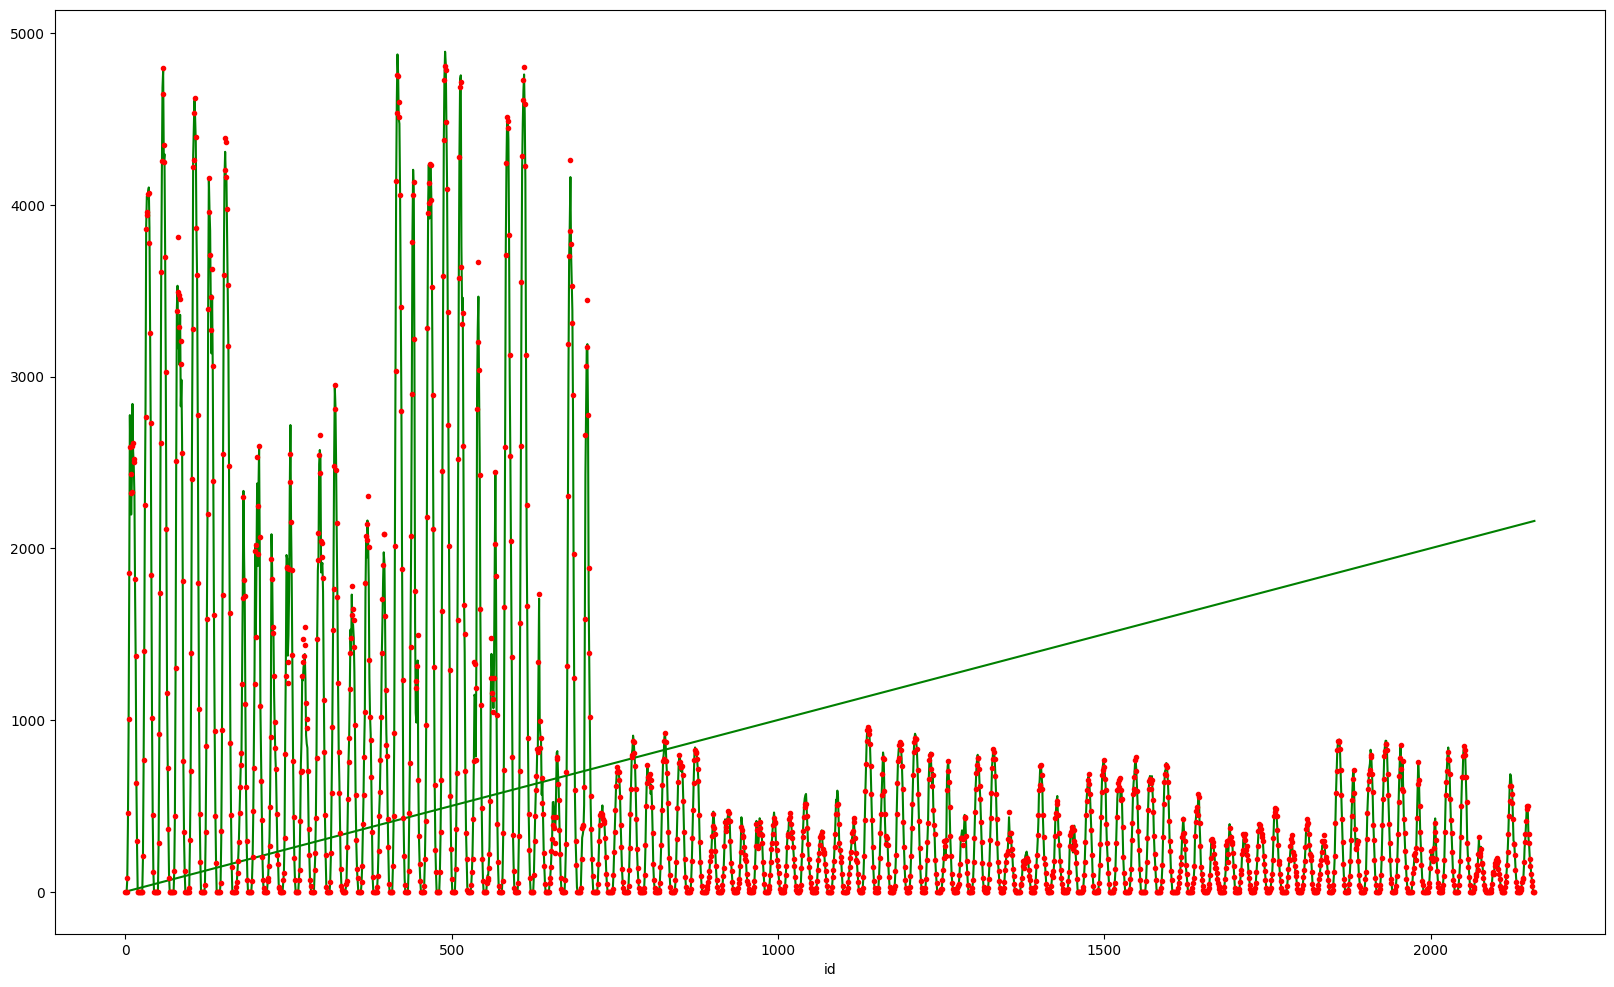

In [107]:
best_submission = pd.read_csv('./submissions/submission_cat_147SUI.csv')
second_best_sub = pd.read_csv('./submissions/submission_cat147+ag146_weighted_60-40.csv')

print(y_pred.shape)
print(best_submission['prediction'].shape)
plt.figure(figsize=(20,12))

plt.plot(second_best_sub, 'g')
plt.plot(best_submission['prediction'], 'r.')
plt.xlabel("id")
plt.show()


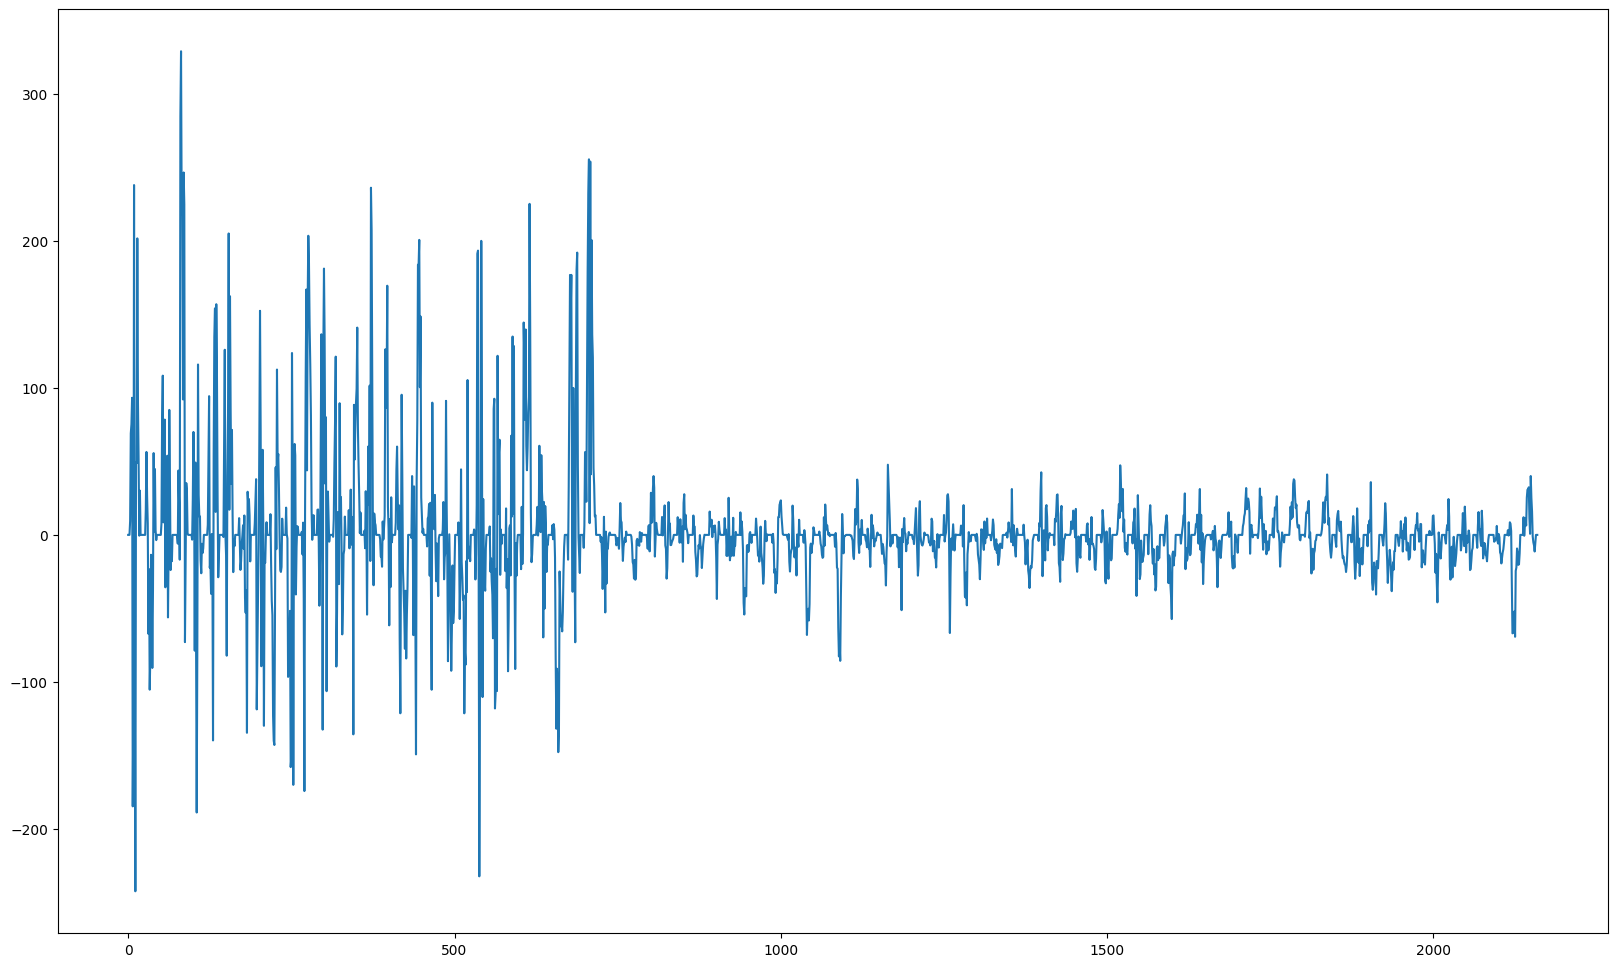

In [108]:
dist = best_submission['prediction'] - second_best_sub['prediction']

plt.figure(figsize=(20,12))
plt.plot(dist)
